# Accessing the [oceanwatch](http://oceanwatch.pifsc.noaa.gov/) data with Python

In [1]:
%matplotlib inline

In [2]:
import os
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np

In [3]:
import requests

### run the following to download the data using the generated URL (you need to copy it from your browser):

In [4]:
url = 'http://oceanwatch.pifsc.noaa.gov/erddap/griddap/OceanWatch_aqua_chla_monthly.nc?chla[(2015-05-01T00:00:00Z):1:(2016-05-01T00:00:00Z)][(17):1:(30)][(195):1:(210)]'

In [5]:
if not os.path.exists('./chl.nc'):
    r = requests.get(url)
    with open('./chl.nc', 'wb') as f:
        f.write(r.content)

### open file

In [6]:
dset= xr.open_dataset('./chl.nc')

In [7]:
dset

<xarray.Dataset>
Dimensions:    (latitude: 261, longitude: 301, time: 13)
Coordinates:
  * time       (time) datetime64[ns] 2015-05-01 2015-06-01 2015-07-01 ...
  * latitude   (latitude) float64 17.0 17.05 17.1 17.15 17.2 17.25 17.3 ...
  * longitude  (longitude) float64 195.0 195.1 195.1 195.2 195.2 195.2 195.3 ...
Data variables:
    chla       (time, latitude, longitude) float64 0.05137 0.05258 0.0549 ...
Attributes:
    acknowledgements:           NASA Goddard Space Flight Center
    cdm_data_type:              Grid
    comment:                    AQUA MODIS Ocean Color data product
    contributor_name:           NOAA OceanWatch - Central Pacific
    contributor_url:            http://oceanwatch.pifsc.noaa.gov
    Conventions:                COARDS, CF-1.6, ACDD-1.3
    creator_email:              NESDIS.Data.Access@noaa.gov
    creator_name:               NOAA/NESDIS/OceanWatch - Central Pacific
    creator_url:                http://www.nesdis.noaa.gov/
    date_created:        

### examine which variables are included in the dataset


In [8]:
dset.var()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    chla     float64 0.0005661

### extract chla 

In [9]:
chl = dset['chla']

### examine structure of chl

In [10]:
chl.dims

('time', 'latitude', 'longitude')

### examine the dates

In [11]:
dset.time

<xarray.DataArray 'time' (time: 13)>
array(['2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
       '2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-05-01 2015-06-01 2015-07-01 ...
Attributes:
    _CoordinateAxisType:  Time
    actual_range:         [  1.43043840e+09   1.46206080e+09]
    axis:                 T
    ioos_category:        Time
    long_name:            Time
    standard_name:        time
    time_origin:          01-JAN-1970 00:00:00

### get lon and lat

In [12]:
lon = dset['longitude']

In [13]:
lat = dset['latitude']

## Working with the data

### Creating a map of Chl a for May 2015 (our first time step)


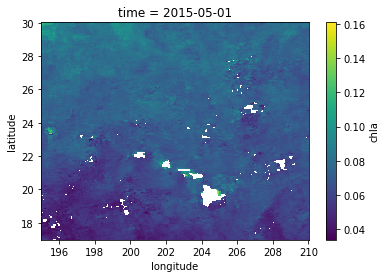

In [14]:
dset.sel(time='2015-05-01')['chla'].plot()

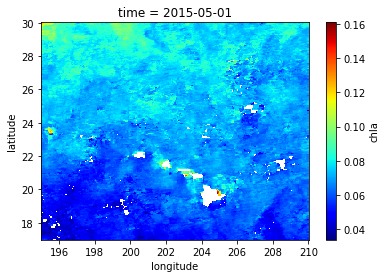

In [15]:
dset.sel(time='2015-05-01')['chla'].plot(cmap=plt.cm.jet)

## Plotting a time-series of median Chlorophyll a concentration in a box

Let's pick the following box : 24-26N, 200-206E

In [16]:
box = dset.sel(longitude=slice(200, 206), latitude=slice(24,26)).mean('latitude').mean('longitude')

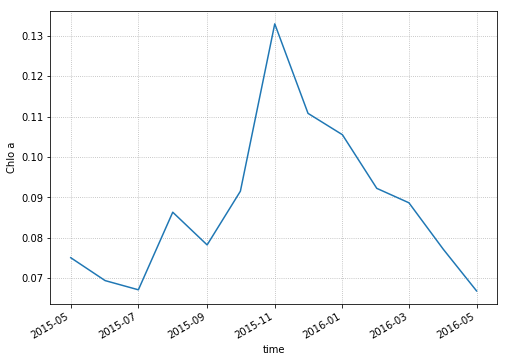

In [17]:
f, ax = plt.subplots(figsize=(8,6))
box['chla'].plot(ax=ax)
ax.set_ylabel('Chlo a')
ax.grid(ls=':')

## Creating a map of median Chl a concentration over a year

In [18]:
median_chla = dset['chla'].median('time')

### Mapping using [cartopy](https://github.com/SciTools/cartopy) 

In [19]:
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy import feature as cfeature

In [20]:
proj = ccrs.PlateCarree()

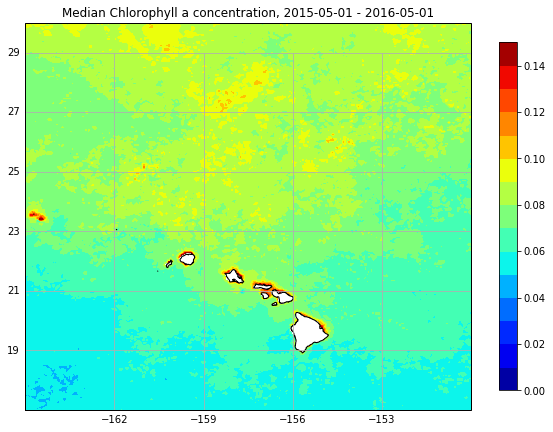

In [21]:
f, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection':proj})

ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])

ax.add_feature(cfeature.GSHHSFeature(scale='full', lw=0.5, facecolor='w'))

im = ax.contourf(lon, lat, median_chla, levels = np.arange(0,0.16,0.01), cmap=plt.cm.jet)

plt.colorbar(im, ax=ax, shrink=0.8)

gl = ax.gridlines(xlocs=lon[::60]-360, ylocs=lat[::40], draw_labels=True)

gl.xlabels_top = gl.ylabels_right = False

ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])

ax.set_xlabel('longitude')

ax.set_ylabel('latitude')

ax.set_title('Median Chlorophyll a concentration, {:%Y-%m-%d} - {:%Y-%m-%d}'.\
             format(dset.time.to_index()[0], dset.time.to_index()[-1]))